In [1]:
import xarray as xr
import hvplot.xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import datetime as dt
import tqdm
from climtas.nci import GadiClient
import glob
import metpy

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(

KeyboardInterrupt



In [ ]:
client = GadiClient()
client

In [ ]:
def load_barra_c2(t1,t2,vname,lat_slice=slice(-90,90),lon_slice=slice(0,360)):
    path = "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/1hr/"+vname+"/v20240809/"
    fnames = np.sort(glob.glob(path+"*.nc"))
    ftimes = np.array([dt.datetime.strptime(f.split("/")[-1].split("_")[-1].split(".")[0].split("-")[0],"%Y%m") for f in fnames])
    
    f = xr.open_mfdataset(fnames[(ftimes>=t1) & (ftimes<=t2)]).sel(lat=lat_slice,lon=lon_slice)
    
    return f

def load_barra_r2(t1,t2,vname,lat_slice=slice(-90,90),lon_slice=slice(0,360)):
    path = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/1hr/"+vname+"/v20240809/"
    fnames = np.sort(glob.glob(path+"*.nc"))
    ftimes = np.array([dt.datetime.strptime(f.split("/")[-1].split("_")[-1].split(".")[0].split("-")[0],"%Y%m") for f in fnames])
    
    f = xr.open_mfdataset(fnames[(ftimes>=t1) & (ftimes<=t2)]).sel(lat=lat_slice,lon=lon_slice)
    
    return f

def combine_winds(u,v,uname,vname,ws_name):

    wind_da = xr.Dataset({uname:u[uname],vname:v[vname]})
    wind_da[ws_name] = np.sqrt(wind_da[uname]**2 + wind_da[vname]**2)

    return wind_da

t1 = dt.datetime(2023,12,1)
t2 = dt.datetime(2024,2,29)
lat_slice = slice(-40,-29)
lon_slice = slice(140,156)

#Load BARRA-R2 winds
wind_ds_list = []
# unames = ["uas","ua50m","ua100m","ua150m","ua200m","ua250m","ua1500m"]
# vnames = ["vas","va50m","va100m","va150m","va200m","va250m","va1500m"]
# ws_names = ["ws_sfc","ws_50m","ws_100m","ws_150m","ws_200m","ws_250m","ws_1500m"]
unames = ["uas","ua1000","ua925","ua850","ua700"]
vnames = ["vas","va1000","va925","va850","va700"]
ws_names = ["ws_sfc","ws_1000","ws_925","ws_850","ws_va700"]

for uname,vname,wsname in zip(unames,vnames,ws_names):
    uas = load_barra_r2(t1,t2,uname,lat_slice,lon_slice)
    vas = load_barra_r2(t1,t2,vname,lat_slice,lon_slice)
    wind_ds_list.append(combine_winds(uas,vas,uname,vname,wsname))
wind_ds = xr.merge(wind_ds_list,compat="override")

#Load other BARRA-R2 scalars
huss = load_barra_r2(t1,t2,"huss",lat_slice,lon_slice)
wa925 = load_barra_r2(t1,t2,"wa925",lat_slice,lon_slice)
tas = load_barra_r2(t1,t2,"tas",lat_slice,lon_slice)
ps = load_barra_r2(t1,t2,"ps",lat_slice,lon_slice)

#Load BARRA-C2 winds
windc_ds_list = []
unames = ["uas"]
vnames = ["vas"]
ws_names = ["ws_sfc"]
for uname,vname,wsname in zip(unames,vnames,ws_names):
    uas = load_barra_c2(t1,t2,uname,lat_slice,lon_slice)
    vas = load_barra_c2(t1,t2,vname,lat_slice,lon_slice)
    windc_ds_list.append(combine_winds(uas,vas,uname,vname,wsname))
windc_ds = xr.merge(windc_ds_list,compat="override")

In [43]:
def plot_sfc_wind(sfc_wind,ax,vmax=None,vmin=None,cmap=None,ws=True):
    if ws:
        sfc_wind.ws_sfc.plot(vmax=vmax,vmin=vmin,cmap=cmap)
    sfc_wind[["uas","vas"]].coarsen({"lon":2,"lat":2},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="uas",v="vas")
    ax.coastlines()
    ax.gridlines(draw_labels=True)

def plot_ds(ds,var_name,ax,vmin=None,vmax=None,cmap=None):
    ds[var_name].plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap)

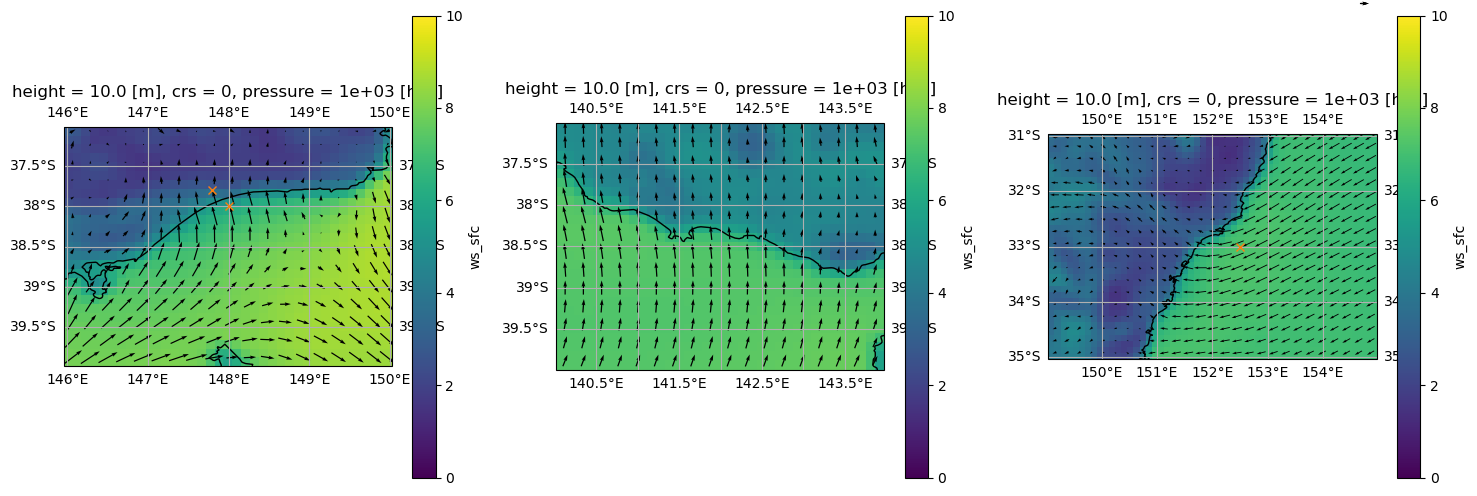

In [36]:
lat_slice_gipps = slice(-40,-37)
lon_slice_gipps = slice(146,150)

lat_slice_swv = slice(-40,-37)
lon_slice_swv = slice(140,144)

lat_slice_hunter = slice(-35,-31)
lon_slice_hunter = slice(149,155)

plt.figure(figsize=[18,6])
ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
plot_sfc_wind(wind_ds.mean("time").sel(lat=lat_slice_gipps,lon=lon_slice_gipps), ax, vmin=0, vmax=10)
plt.gca().plot(148,-38,marker="x",color="tab:orange")
plt.gca().plot(147.8,-37.8,marker="x",color="tab:orange")

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
plot_sfc_wind(wind_ds.mean("time").sel(lat=lat_slice_swv,lon=lon_slice_swv), ax, vmin=0, vmax=10)
#plt.gca().plot(152.5,-33,marker="x",color="tab:orange")

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
plot_sfc_wind(wind_ds.mean("time").sel(lat=lat_slice_hunter,lon=lon_slice_hunter), ax, vmin=0, vmax=10)
plt.gca().plot(152.5,-33,marker="x",color="tab:orange")

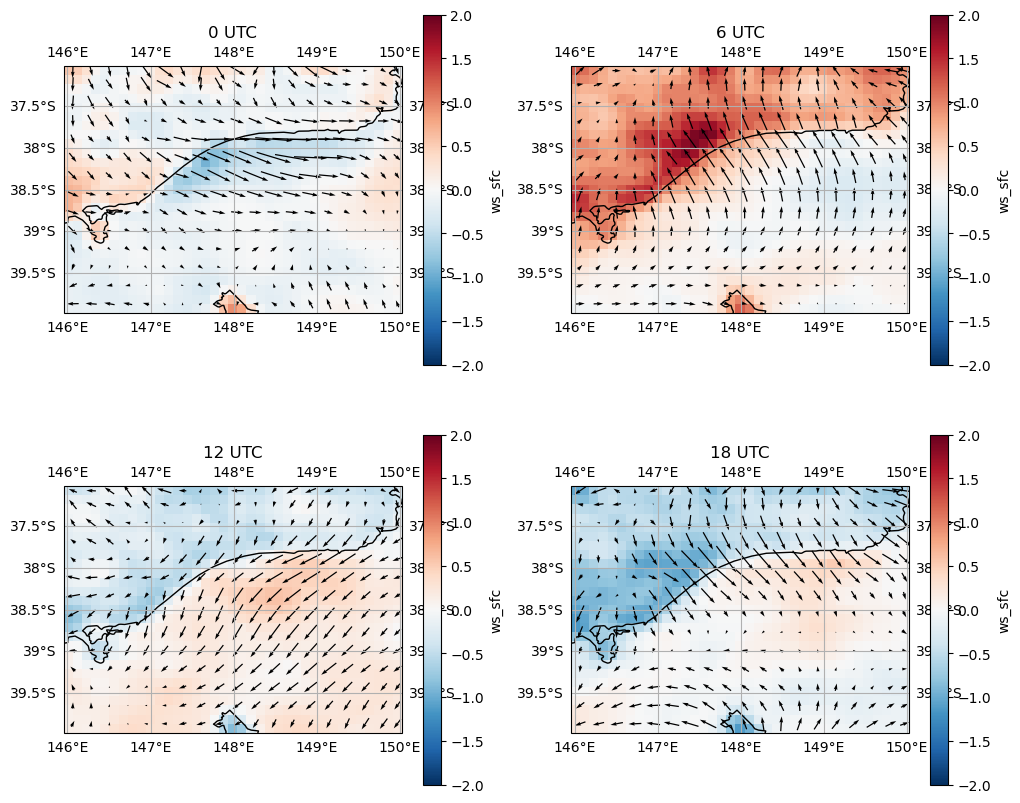

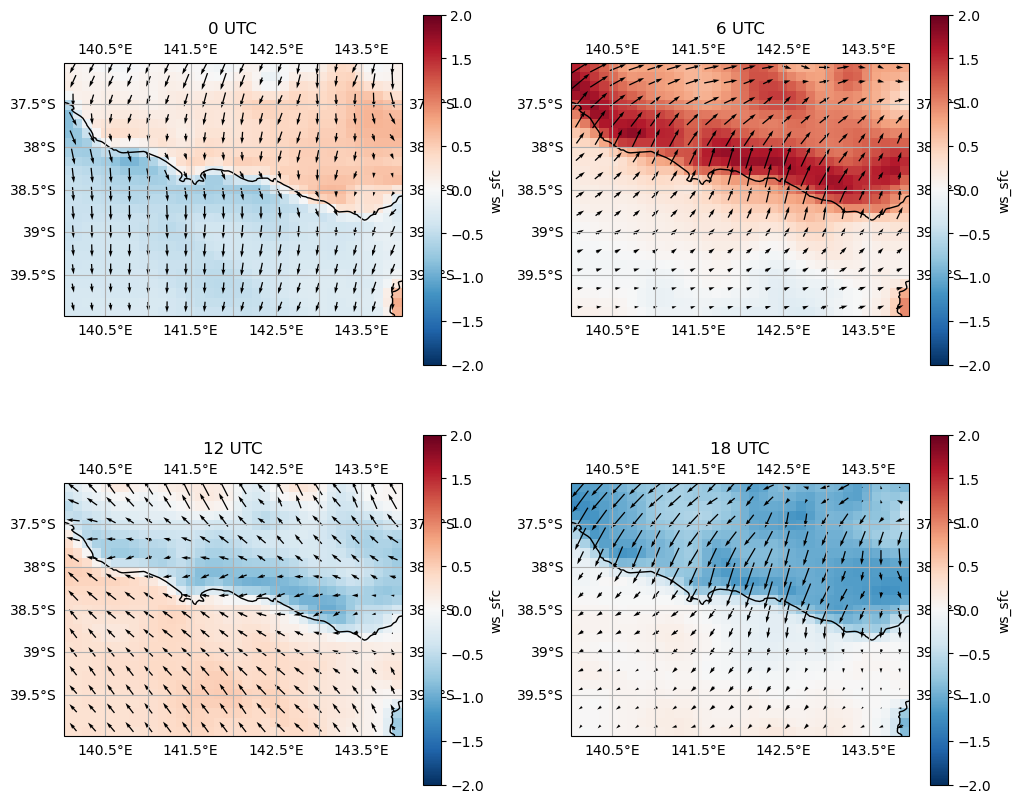

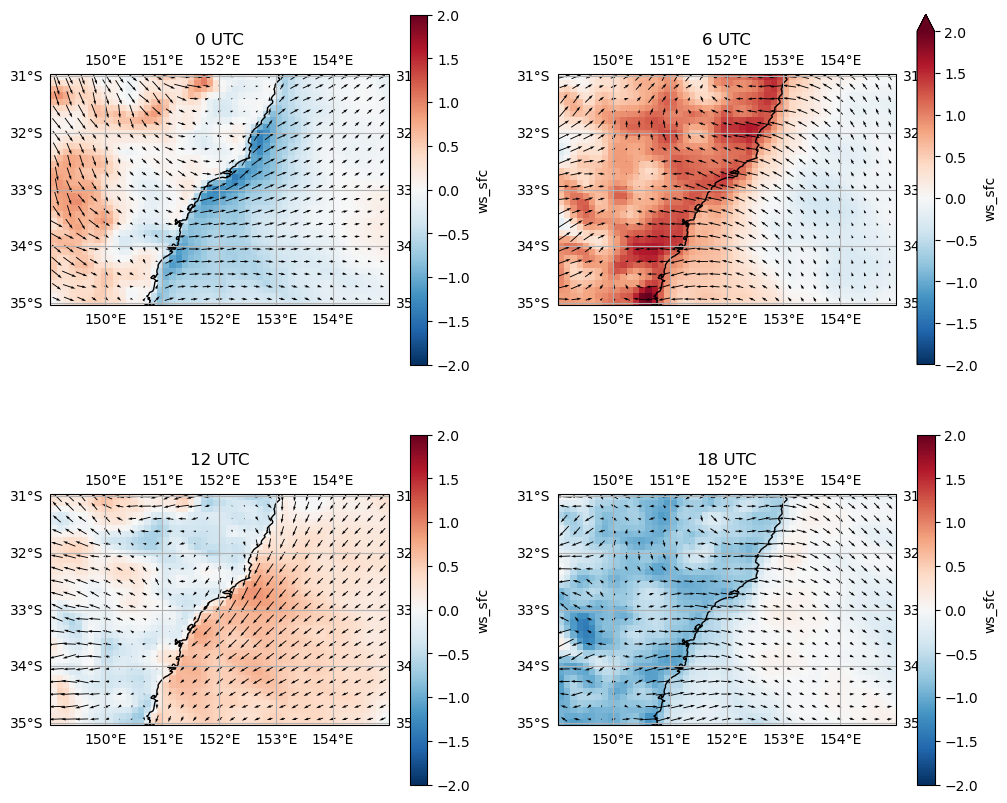

In [39]:
cnt=1
plt.figure(figsize=[12,10])
for hour in [0,6,12,18]:
    ax=plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())
    plot_sfc_wind(wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps).groupby("time.hour").mean().sel(hour=hour) - wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps).mean("time"),
                 ax=ax,vmin=-2,vmax=2, cmap="RdBu_r")
    plt.title(str(hour) +" UTC")
    cnt=cnt+1

cnt=1
plt.figure(figsize=[12,10])
for hour in [0,6,12,18]:
    ax=plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())
    plot_sfc_wind(wind_ds.sel(lat=lat_slice_swv,lon=lon_slice_swv).groupby("time.hour").mean().sel(hour=hour) - wind_ds.sel(lat=lat_slice_swv,lon=lon_slice_swv).mean("time"),
                 ax=ax,vmin=-2,vmax=2, cmap="RdBu_r")
    plt.title(str(hour) +" UTC")
    cnt=cnt+1

cnt=1
plt.figure(figsize=[12,10])
for hour in [0,6,12,18]:
    ax=plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())
    plot_sfc_wind(wind_ds.sel(lat=lat_slice_hunter,lon=lon_slice_hunter).groupby("time.hour").mean().sel(hour=hour) - wind_ds.sel(lat=lat_slice_hunter,lon=lon_slice_hunter).mean("time"),
                  ax=ax,vmin=-2,vmax=2, cmap="RdBu_r")
    plt.title(str(hour) +" UTC")    
    cnt=cnt+1


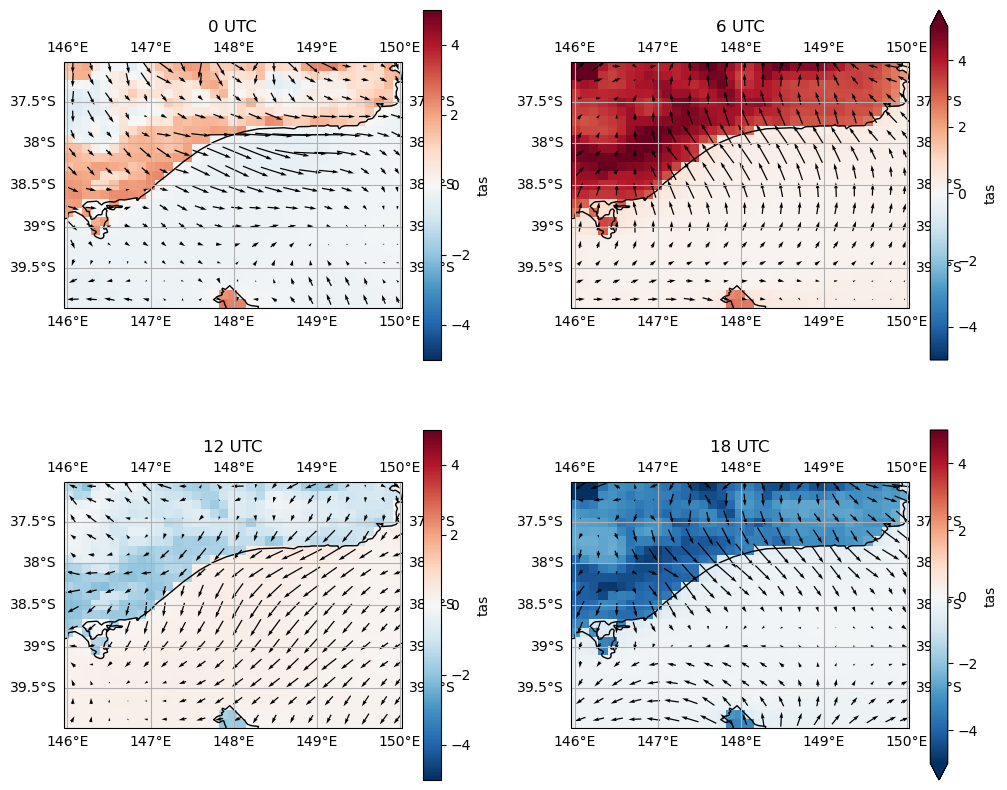

In [49]:
plt.figure(figsize=[12,10])
cnt=1
for hour in [0,6,12,18]:
    ax=plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())
    plot_ds(tas.sel(lat=lat_slice_gipps,lon=lon_slice_gipps).groupby("time.hour").mean().sel(hour=hour) - tas.sel(lat=lat_slice_gipps,lon=lon_slice_gipps).mean("time"),
            "tas",ax,vmin=-5,vmax=5,cmap="RdBu_r")
    plot_sfc_wind(wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps).groupby("time.hour").mean().sel(hour=hour) - wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps).mean("time"),
                 ax=ax,ws=False)
    plt.title(str(hour) +" UTC")
    cnt=cnt+1

Text(0.5, 1.0, 'Hunter valley hodograph (anomaly)')

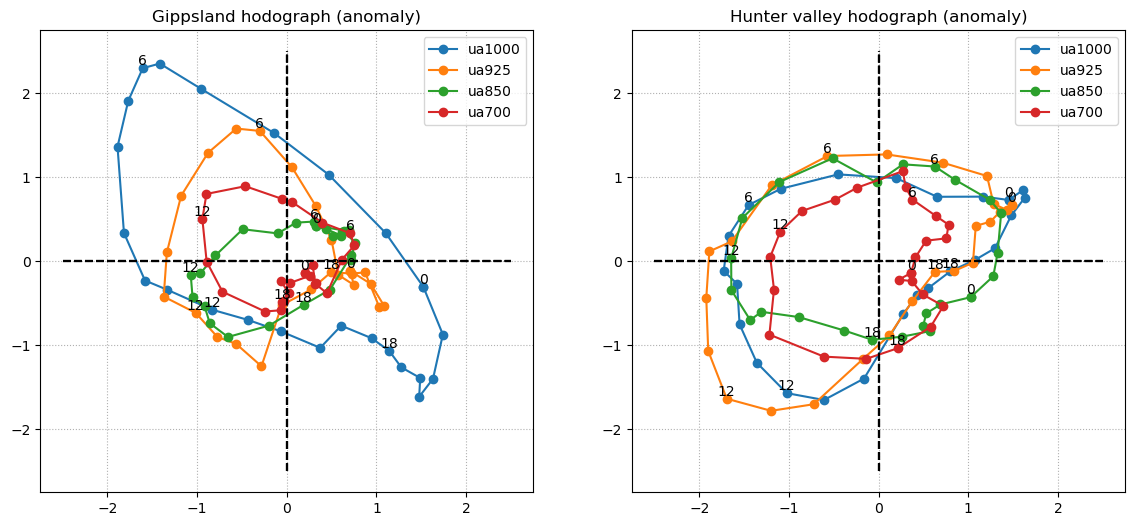

In [7]:
unames = ["ua1000","ua925","ua850","ua700"]
vnames = ["va1000","va925","va850","va700"]

plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
lat = -38
lon=148
for uname,vname in zip(unames,vnames):
    mean_u = wind_ds.sel(lat=lat,lon=lon,method="nearest")[uname].mean().values
    mean_v = wind_ds.sel(lat=lat,lon=lon,method="nearest")[vname].mean().values
    
    u_comp = wind_ds.sel(lat=lat,lon=lon,method="nearest").groupby("time.hour").mean()[uname].values
    v_comp = wind_ds.sel(lat=lat,lon=lon,method="nearest").groupby("time.hour").mean()[vname].values
    u_comp = np.append(u_comp,u_comp[0]) - mean_u
    v_comp = np.append(v_comp,v_comp[0]) - mean_v
    
    plt.plot(u_comp,v_comp,marker="o",label=uname)
    [plt.text(u_comp[i],v_comp[i],str(i),ha="center",va="bottom",size=10) for i in [0,6,12,18]]
    plt.gca().grid(ls=":")
    plt.plot([0,0],[-2.5,2.5],color="k",ls="--")
    plt.plot([-2.5,2.5],[0,0],color="k",ls="--")
plt.legend()
plt.title("Gippsland hodograph (anomaly)")

plt.subplot(1,2,2)
lat = -33
lon=152.5
for uname,vname in zip(unames,vnames):
    mean_u = wind_ds.sel(lat=lat,lon=lon,method="nearest")[uname].mean().values
    mean_v = wind_ds.sel(lat=lat,lon=lon,method="nearest")[vname].mean().values
    
    u_comp = wind_ds.sel(lat=lat,lon=lon,method="nearest").groupby("time.hour").mean()[uname].values
    v_comp = wind_ds.sel(lat=lat,lon=lon,method="nearest").groupby("time.hour").mean()[vname].values
    u_comp = np.append(u_comp,u_comp[0]) - mean_u
    v_comp = np.append(v_comp,v_comp[0]) - mean_v
    
    plt.plot(u_comp,v_comp,marker="o",label=uname)
    [plt.text(u_comp[i],v_comp[i],str(i),ha="center",va="bottom",size=10) for i in [0,6,12,18]]
    plt.gca().grid(ls=":")
    plt.plot([0,0],[-2.5,2.5],color="k",ls="--")
    plt.plot([-2.5,2.5],[0,0],color="k",ls="--")

plt.legend()

plt.title("Hunter valley hodograph (anomaly)")

Text(0.5, 1.0, 'Hunter valley hodograph (total wind)')

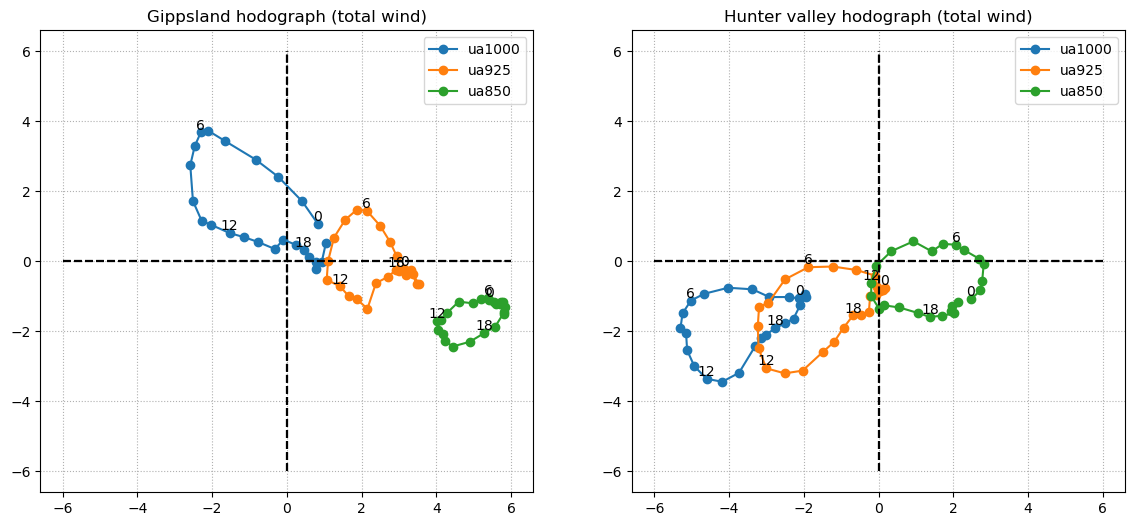

In [8]:
unames = ["ua1000","ua925","ua850"]
vnames = ["va1000","va925","va850"]

plt.figure(figsize=[14,6])
plt.subplot(1,2,1)
lat = -38
lon=148
for uname,vname in zip(unames,vnames):
    u_comp = wind_ds.sel(lat=lat,lon=lon,method="nearest").groupby("time.hour").mean()[uname].values
    v_comp = wind_ds.sel(lat=lat,lon=lon,method="nearest").groupby("time.hour").mean()[vname].values
    
    plt.plot(u_comp,v_comp,marker="o",label=uname)
    [plt.text(u_comp[i],v_comp[i],str(i),ha="center",va="bottom",size=10) for i in [0,6,12,18]]
    plt.gca().grid(ls=":")
    plt.plot([0,0],[-6,6],color="k",ls="--")
    plt.plot([-6,6],[0,0],color="k",ls="--") 
plt.legend()
plt.title("Gippsland hodograph (total wind)")

plt.subplot(1,2,2)
lat = -33
lon=152.5
for uname,vname in zip(unames,vnames):
    u_comp = wind_ds.sel(lat=lat,lon=lon,method="nearest").groupby("time.hour").mean()[uname].values
    v_comp = wind_ds.sel(lat=lat,lon=lon,method="nearest").groupby("time.hour").mean()[vname].values
    
    plt.plot(u_comp,v_comp,marker="o",label=uname)
    [plt.text(u_comp[i],v_comp[i],str(i),ha="center",va="bottom",size=10) for i in [0,6,12,18]]
    plt.gca().grid(ls=":")
    plt.plot([0,0],[-6,6],color="k",ls="--")
    plt.plot([-6,6],[0,0],color="k",ls="--")

plt.legend()

plt.title("Hunter valley hodograph (total wind)")

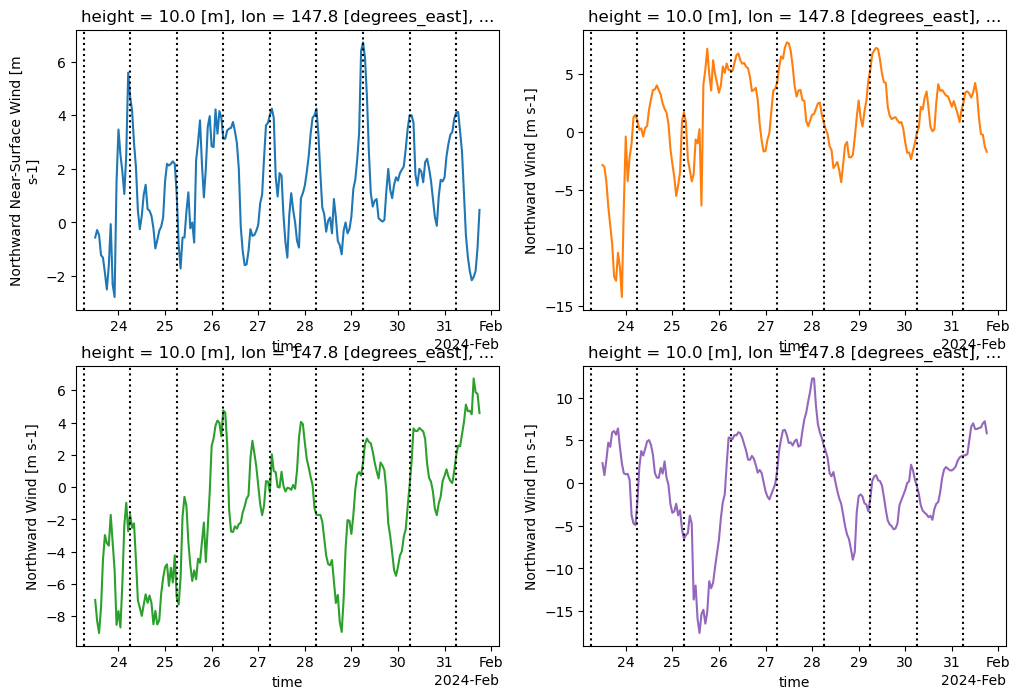

In [50]:
plt.figure(figsize=[12,8])

start_t = "2024-1-23 12:00"
end_t = "2024-1-31 18:00"

plt.subplot(2,2,1)
wind_ds.sel(time=slice(start_t,end_t)).sel(lon=147.8,lat=-37.8,method="nearest").vas.plot()
for t in [dt.datetime.strptime(start_t,"%Y-%m-%d %H:%M") + dt.timedelta(days=i) for i in range(100) ]:
    if t <= dt.datetime.strptime(end_t,"%Y-%m-%d %H:%M"):
        plt.gca().axvline(t.replace(hour=6),ls=":",color="k")
    else:
        break

plt.subplot(2,2,2)
wind_ds.sel(time=slice(start_t,end_t)).sel(lon=147.8,lat=-37.8,method="nearest").va925.plot(color="tab:orange")
for t in [dt.datetime.strptime(start_t,"%Y-%m-%d %H:%M") + dt.timedelta(days=i) for i in range(100) ]:
    if t <= dt.datetime.strptime(end_t,"%Y-%m-%d %H:%M"):
        plt.gca().axvline(t.replace(hour=6),ls=":",color="k")
    else:
        break

plt.subplot(2,2,3)
wind_ds.sel(time=slice(start_t,end_t)).sel(lon=147.8,lat=-37.8,method="nearest").va850.plot(color="tab:green")
for t in [dt.datetime.strptime(start_t,"%Y-%m-%d %H:%M") + dt.timedelta(days=i) for i in range(100) ]:
    if t <= dt.datetime.strptime(end_t,"%Y-%m-%d %H:%M"):
        plt.gca().axvline(t.replace(hour=6),ls=":",color="k")
    else:
        break

plt.subplot(2,2,4)
wind_ds.sel(time=slice(start_t,end_t)).sel(lon=147.8,lat=-37.8,method="nearest").va700.plot(color="tab:purple")
for t in [dt.datetime.strptime(start_t,"%Y-%m-%d %H:%M") + dt.timedelta(days=i) for i in range(100) ]:
    if t <= dt.datetime.strptime(end_t,"%Y-%m-%d %H:%M"):
        plt.gca().axvline(t.replace(hour=6),ls=":",color="k")
    else:
        break

In [20]:
wind_ds

<xarray.Dataset> Size: 4GB
Dimensions:   (time: 2184, lon: 145, lat: 100)
Coordinates:
  * time      (time) datetime64[ns] 17kB 2023-12-01 ... 2024-02-29T23:00:00
    height    float64 8B 10.0
  * lon       (lon) float64 1kB 140.1 140.2 140.3 140.4 ... 155.7 155.8 155.9
  * lat       (lat) float64 800B -39.93 -39.82 -39.71 ... -29.26 -29.15 -29.04
    crs       int32 4B 0
    pressure  float64 8B 1e+03
Data variables: (12/15)
    uas       (time, lat, lon) float64 253MB dask.array<chunksize=(16, 32, 26), meta=np.ndarray>
    vas       (time, lat, lon) float64 253MB dask.array<chunksize=(16, 34, 26), meta=np.ndarray>
    ws_sfc    (time, lat, lon) float64 253MB dask.array<chunksize=(16, 32, 26), meta=np.ndarray>
    ua1000    (time, lat, lon) float64 253MB dask.array<chunksize=(16, 32, 26), meta=np.ndarray>
    va1000    (time, lat, lon) float64 253MB dask.array<chunksize=(16, 30, 26), meta=np.ndarray>
    ws_1000   (time, lat, lon) float64 253MB dask.array<chunksize=(16, 30, 26), meta=np.ndarray>
    ...        ...
    ua850     (time, lat, lon) float64 253MB dask.array<chunksize=(16, 34, 26), meta=np.ndarray>
    va850     (time, lat, lon) float64 253MB dask.array<chunksize=(16, 34, 26), meta=np.ndarray>
    ws_850    (time, lat, lon) float64 253MB dask.array<chunksize=(16, 34, 26), meta=np.ndarray>
    ua700     (time, lat, lon) float64 253MB dask.array<chunksize=(16, 32, 26), meta=np.ndarray>
    va700     (time, lat, lon) float64 253MB dask.array<chunksize=(16, 32, 26), meta=np.ndarray>
    ws_va700  (time, lat, lon) float64 253MB dask.array<chunksize=(16, 32, 26), meta=np.ndarray>

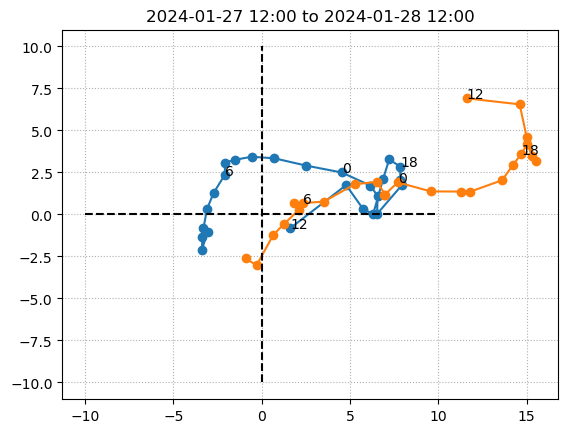

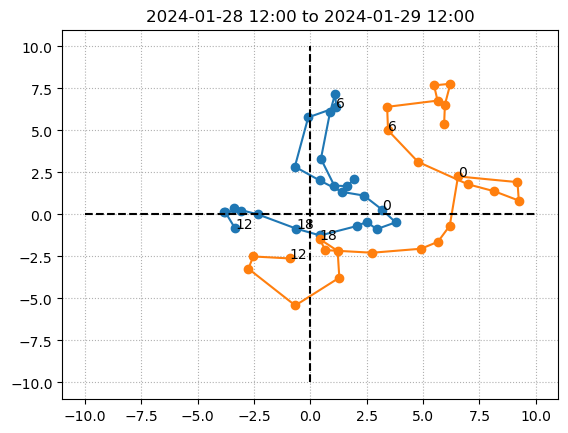

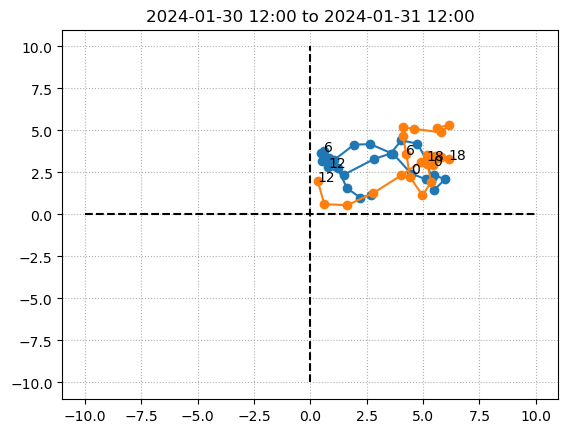

In [11]:
def plot_hodo(sfc_wind):

    for uname,vname,color in zip(["uas","ua925"],["vas","va925"],["tab:blue","tab:orange"]):
        u_comp = sfc_wind[uname].values
        v_comp = sfc_wind[vname].values
        
        plt.plot(u_comp,v_comp,color=color,marker="o")
        [plt.text(u_comp[i],v_comp[i],h) for i,h in zip([0,6,12,18],[12,18,0,6])]
        plt.gca().grid(ls=":")
    
    plt.plot([0,0],[-10,10],color="k",ls="--")
    plt.plot([-10,10],[0,0],color="k",ls="--")

lat = -38
lon=148
for t in [27,28,30]:
    plt.figure()
    date1 = dt.datetime(2024,1,t,12)
    date2 = date1 + dt.timedelta(days=1)
    plot_hodo(wind_ds.sel(time=slice(date1,date2)).sel(lon=lon,lat=lat,method="nearest"))
    plt.title(date1.strftime("%Y-%m-%d %H:%M") + " to " + date2.strftime("%Y-%m-%d %H:%M"))

In [18]:
def plot_wind(wind_ds,uname,vname,ax,coarsen=1,scale=None):
    wind_ds[[uname,vname]].coarsen({"lon":coarsen,"lat":coarsen},boundary="pad").mean().plot.quiver(x="lon",y="lat",u=uname,v=vname,scale=scale)

def plot_divergence(wind_ds,uname,vname,ax):
    (metpy.calc.divergence(wind_ds[uname], wind_ds[vname], x_dim=2, y_dim=1)*1000).rename("Divergence 1000*[1/s]").plot(vmin=-0.2,vmax=0.2,cmap="RdBu_r",extend="both")

def plot_ds(ds,var_name,ax,vmin=None,vmax=None,cmap=None):
    ds[var_name].plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap)

def plot_frontogenesis(ps, tas, wind_ds, ax,vmin=None,vmax=None):
    theta = metpy.calc.potential_temperature(ps,tas)
    metpy.calc.frontogenesis(theta, wind_ds.uas, wind_ds.vas, x_dim=2, y_dim=1).rename("Frontogenesis function [Kelvin/(m s)]").plot(ax=ax,vmin=vmin,vmax=vmax,cmap="RdBu_r")

100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


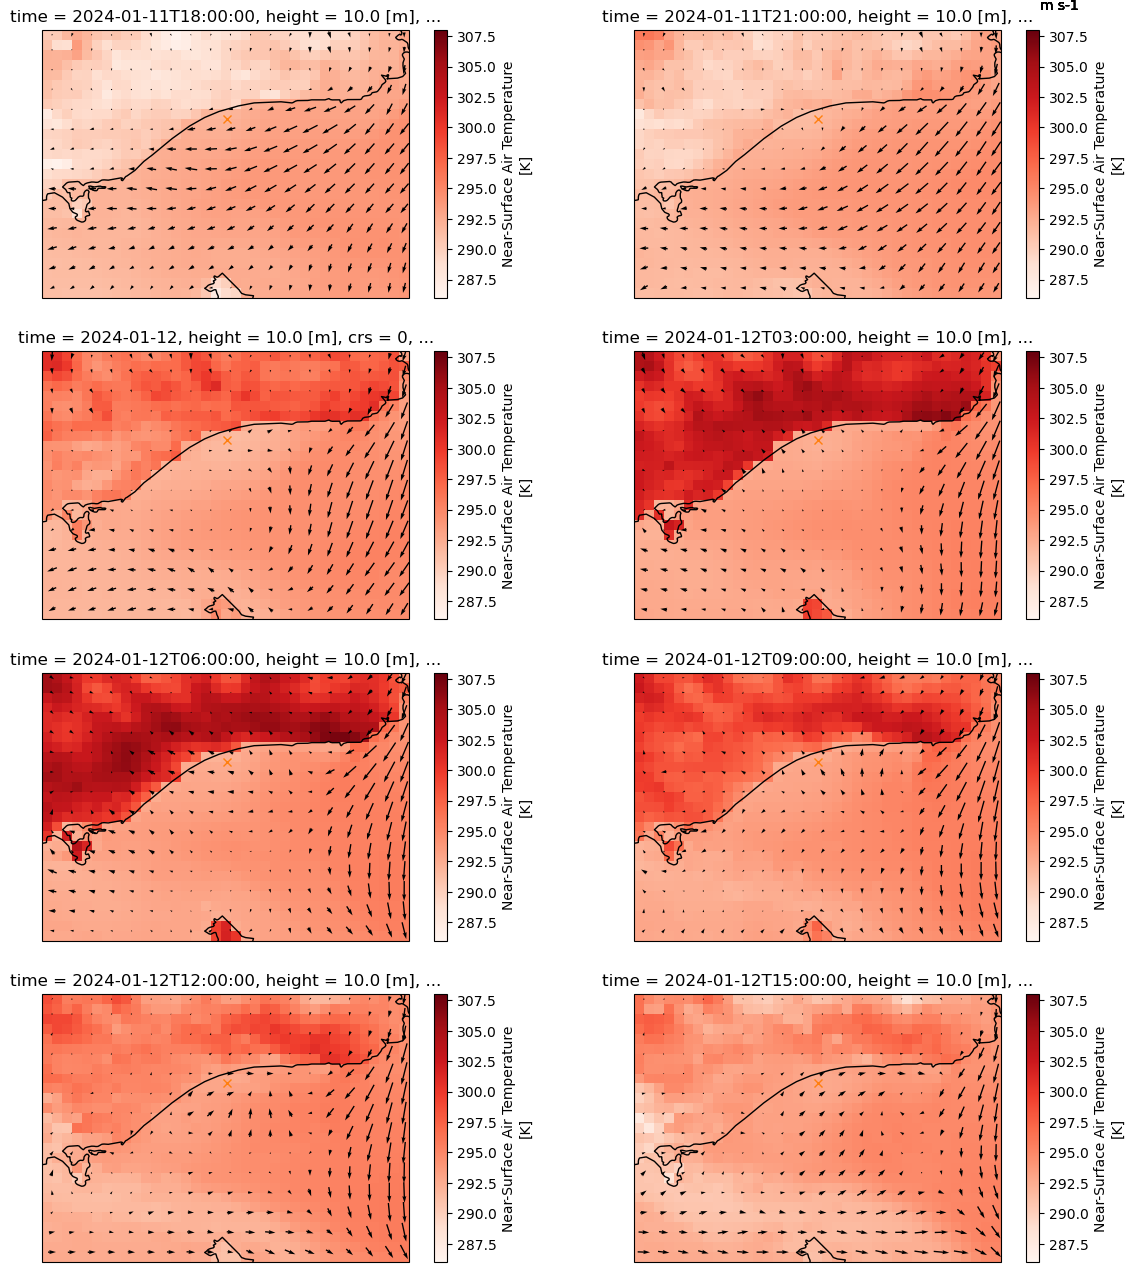

In [26]:
plt.figure(figsize=[14,16])
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2024-01-11 18:00","%Y-%m-%d %H:%M") + dt.timedelta(hours=i) for i in range(0,24,3) ]):
    ax = plt.subplot(4,2,cnt,projection=ccrs.PlateCarree())

    plot_ds(tas.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "tas", ax, vmin=286, vmax=308,cmap="Reds")
    plot_wind(wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "uas", "vas",ax,coarsen=2,scale=200)
    
    ax.plot(148,-38,marker="x",color="tab:orange")
    ax.coastlines()
    #plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    #plt.close()
    cnt=cnt+1

100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


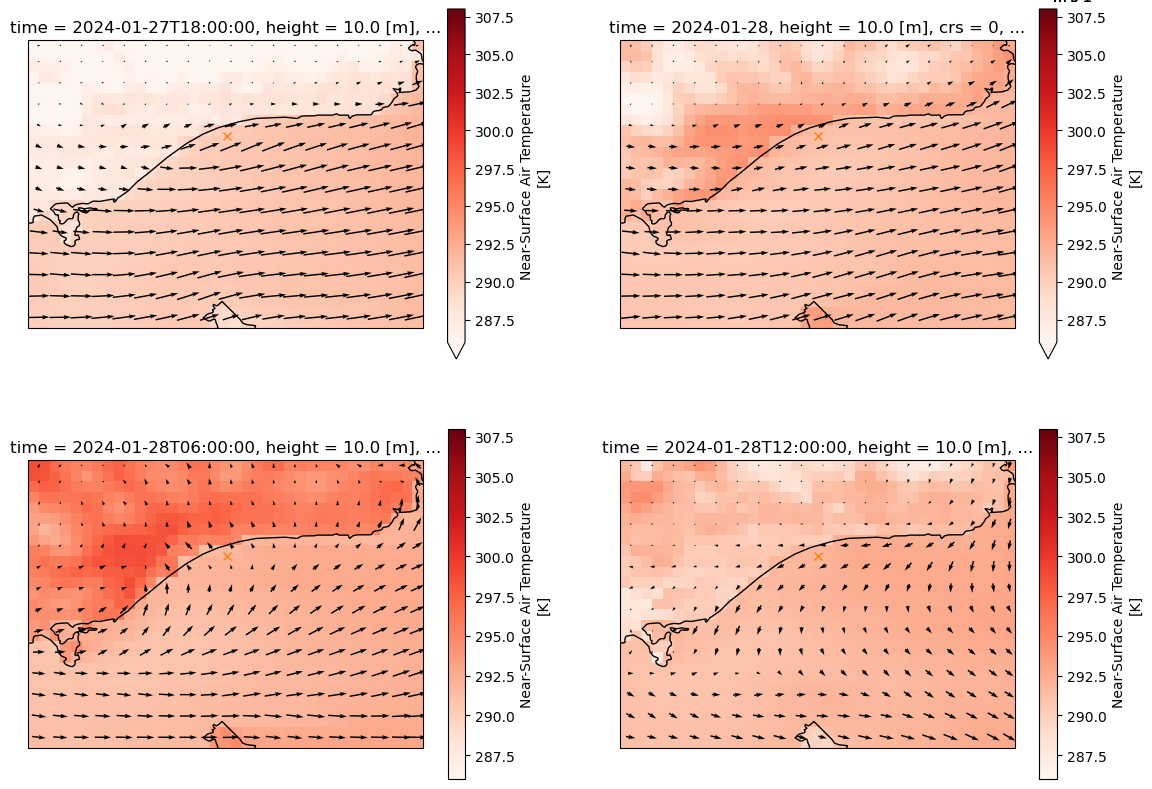

In [51]:
plt.figure(figsize=[14,10])
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2024-01-27 18:00","%Y-%m-%d %H:%M") + dt.timedelta(hours=i) for i in range(0,24,6) ]):
    ax = plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())

    plot_ds(tas.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "tas", ax, vmin=286, vmax=308,cmap="Reds")
    plot_wind(wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "uas", "vas",ax,coarsen=2,scale=200)
    
    ax.plot(148,-38,marker="x",color="tab:orange")
    ax.coastlines()
    #plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    #plt.close()
    cnt=cnt+1

100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


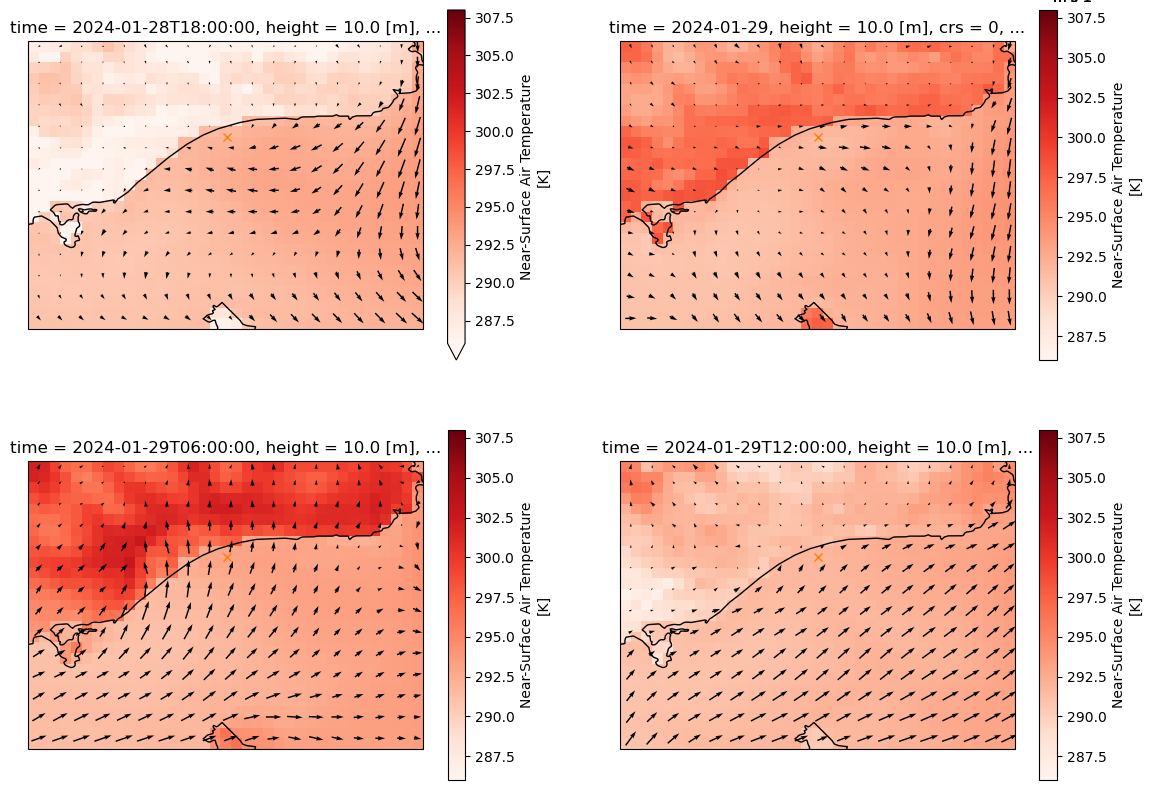

In [52]:
plt.figure(figsize=[14,10])
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2024-01-28 18:00","%Y-%m-%d %H:%M") + dt.timedelta(hours=i) for i in range(0,24,6) ]):
    ax = plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())

    plot_ds(tas.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "tas", ax, vmin=286, vmax=308,cmap="Reds")
    plot_wind(wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "uas", "vas",ax,coarsen=2,scale=200)
    
    ax.plot(148,-38,marker="x",color="tab:orange")
    ax.coastlines()
    #plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    #plt.close()
    cnt=cnt+1

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


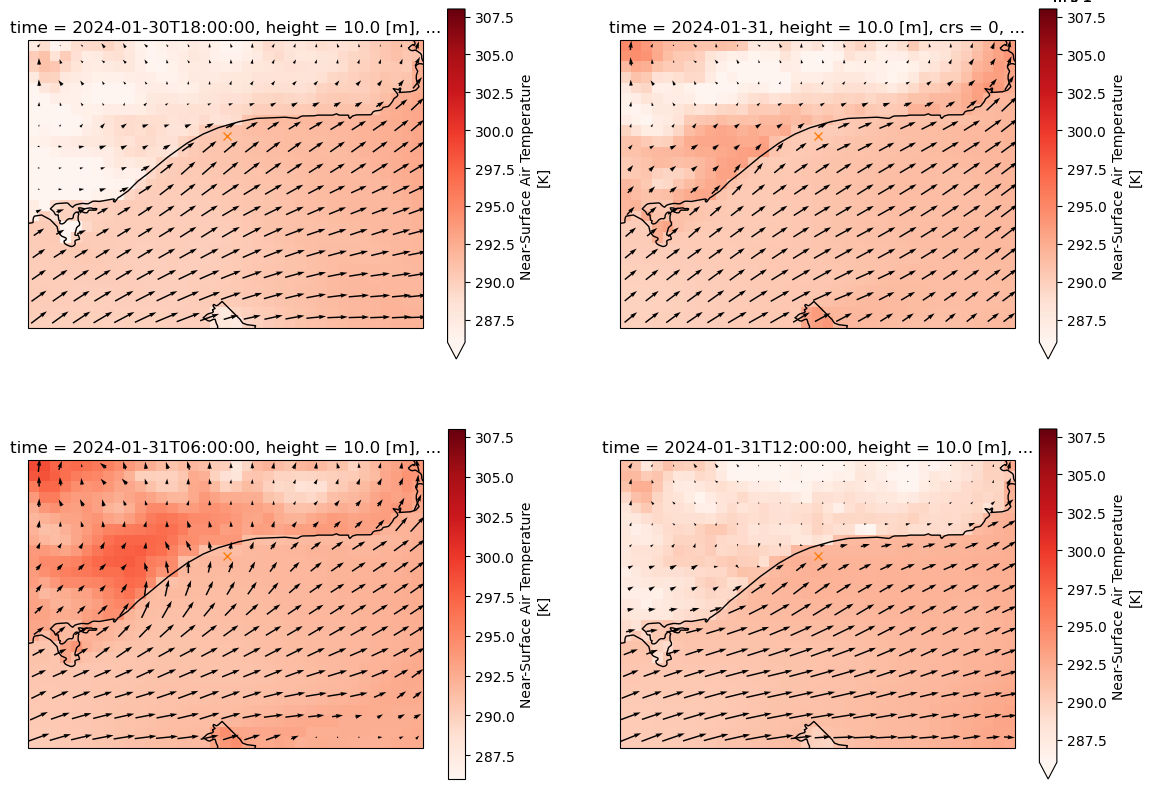

In [18]:
plt.figure(figsize=[14,10])
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2024-01-30 18:00","%Y-%m-%d %H:%M") + dt.timedelta(hours=i) for i in range(0,24,6) ]):
    ax = plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())

    plot_ds(tas.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "tas", ax, vmin=286, vmax=308,cmap="Reds")
    plot_wind(wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "uas", "vas",ax,coarsen=2)
    
    ax.plot(148,-38,marker="x",color="tab:orange")
    ax.coastlines()
    #plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    #plt.close()
    cnt=cnt+1

100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


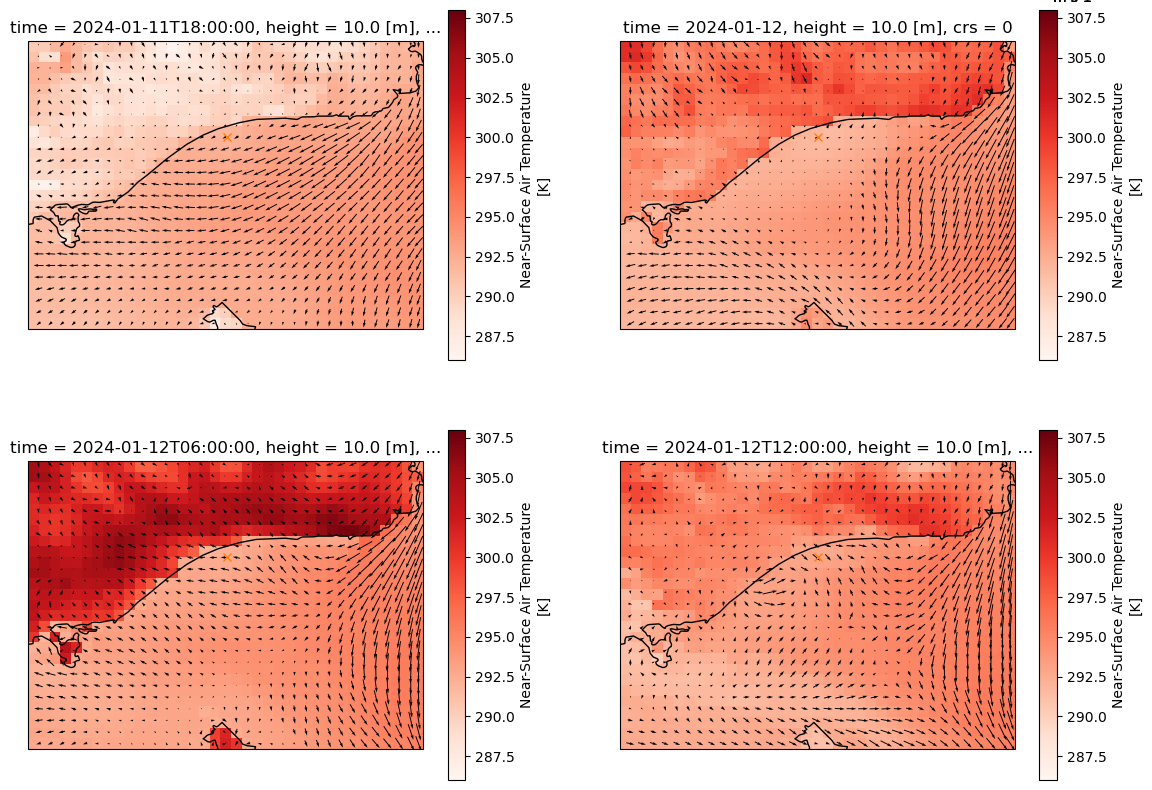

In [69]:
plt.figure(figsize=[14,10])
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2024-01-11 18:00","%Y-%m-%d %H:%M") + dt.timedelta(hours=i) for i in range(0,24,6) ]):
    ax = plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())

    plot_ds(tas.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "tas", ax, vmin=286, vmax=308,cmap="Reds")
    plot_wind(windc_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "uas", "vas",ax,coarsen=3)
    
    ax.plot(148,-38,marker="x",color="tab:orange")
    ax.coastlines()
    #plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    #plt.close()
    cnt=cnt+1

  0%|          | 0/4 [00:00<?, ?it/s]/jobfs/123709570.gadi-pbs/ipykernel_805962/2416644526.py:6: UserWarning: More than one vertical coordinate present for variable  "uas".
  (metpy.calc.divergence(wind_ds[uname], wind_ds[vname], x_dim=2, y_dim=1)*1000).plot(vmin=-0.2,vmax=0.2,cmap="RdBu_r",extend="both")
 25%|██▌       | 1/4 [00:01<00:03,  1.22s/it]/jobfs/123709570.gadi-pbs/ipykernel_805962/2416644526.py:6: UserWarning: More than one vertical coordinate present for variable  "uas".
  (metpy.calc.divergence(wind_ds[uname], wind_ds[vname], x_dim=2, y_dim=1)*1000).plot(vmin=-0.2,vmax=0.2,cmap="RdBu_r",extend="both")
 50%|█████     | 2/4 [00:02<00:02,  1.21s/it]/jobfs/123709570.gadi-pbs/ipykernel_805962/2416644526.py:6: UserWarning: More than one vertical coordinate present for variable  "uas".
  (metpy.calc.divergence(wind_ds[uname], wind_ds[vname], x_dim=2, y_dim=1)*1000).plot(vmin=-0.2,vmax=0.2,cmap="RdBu_r",extend="both")
 75%|███████▌  | 3/4 [00:03<00:01,  1.23s/it]/jobfs/123709570.g

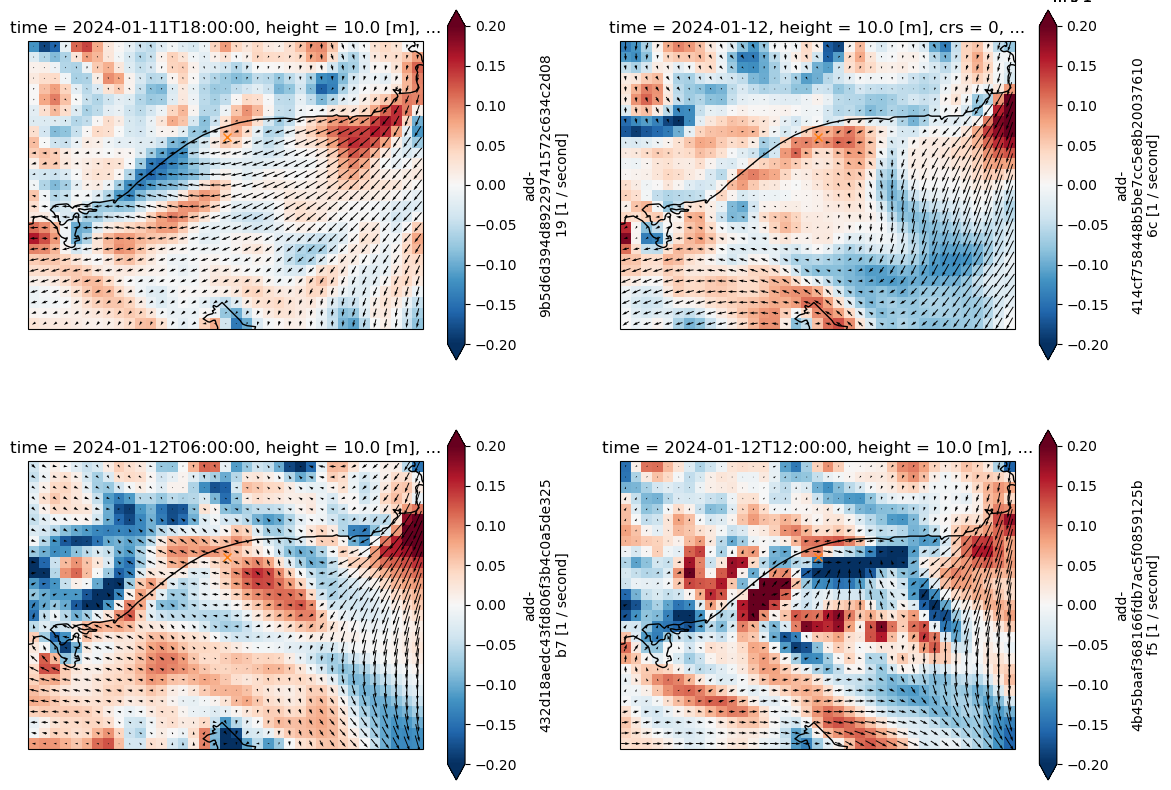

In [43]:
plt.figure(figsize=[14,10])
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2024-01-11 18:00","%Y-%m-%d %H:%M") + dt.timedelta(hours=i) for i in range(0,24,6) ]):
    ax = plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())

    plot_divergence(wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "uas", "vas",ax)
    plot_wind(wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "uas", "vas",ax)
    
    ax.plot(148,-38,marker="x",color="tab:orange")
    ax.coastlines()
    #plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    #plt.close()
    cnt=cnt+1

100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


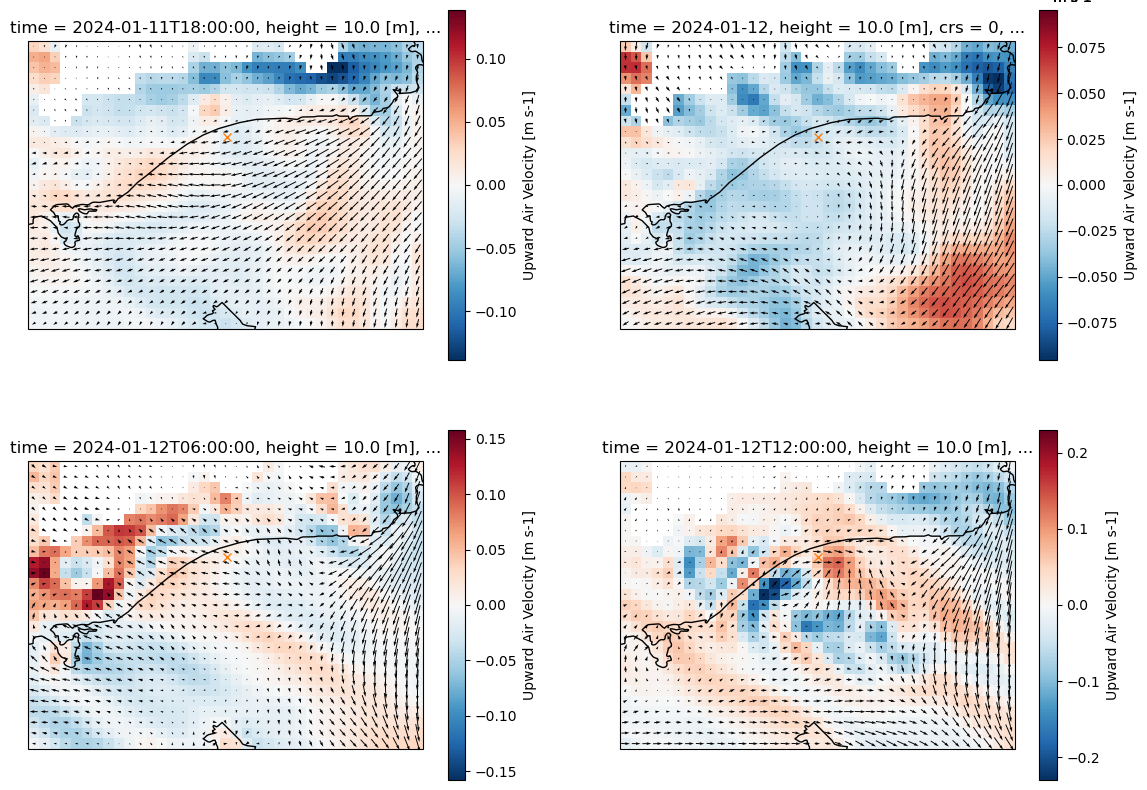

In [42]:
plt.figure(figsize=[14,10])
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2024-01-11 18:00","%Y-%m-%d %H:%M") + dt.timedelta(hours=i) for i in range(0,24,6) ]):
    ax = plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())

    plot_ds(wa925.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "wa925", ax)
    plot_wind(wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "uas", "vas",ax)
    
    ax.plot(148,-38,marker="x",color="tab:orange")
    ax.coastlines()
    cnt=cnt+1

100%|██████████| 4/4 [00:21<00:00,  5.43s/it]


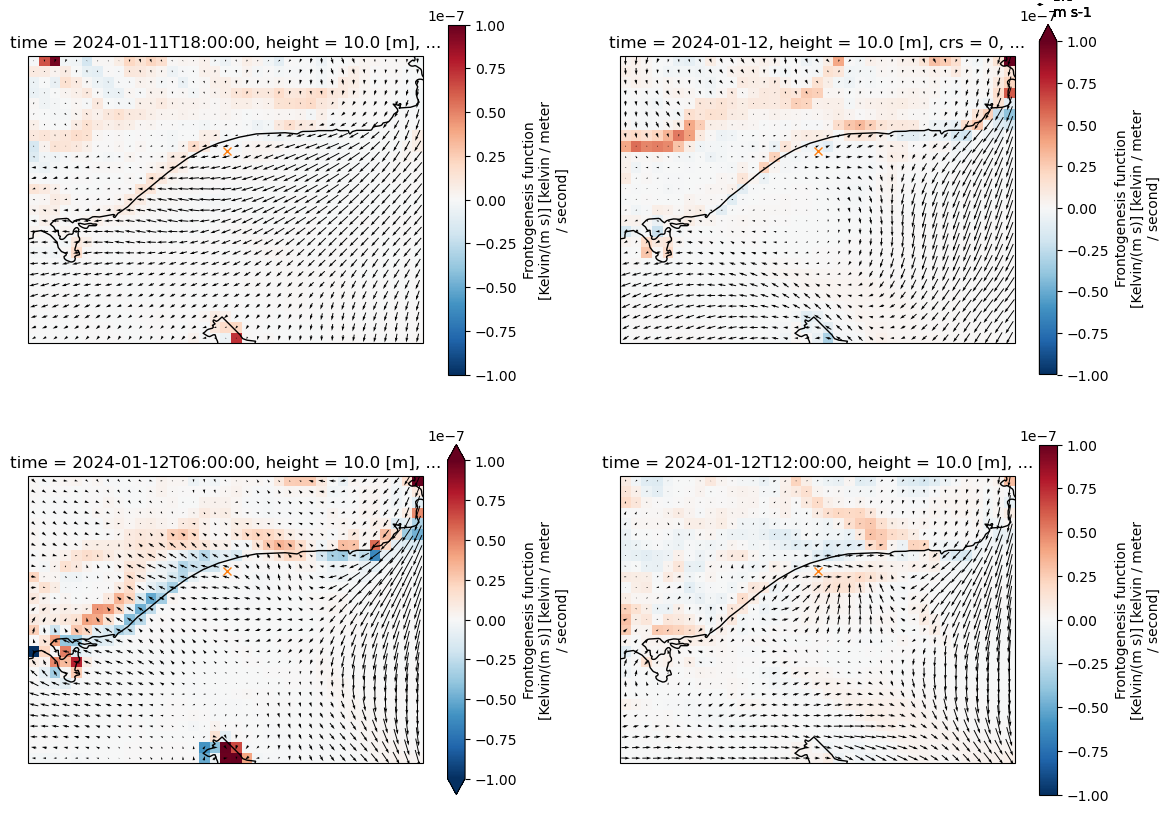

In [63]:
plt.figure(figsize=[14,10])
cnt=1
for t in tqdm.tqdm([dt.datetime.strptime("2024-01-11 18:00","%Y-%m-%d %H:%M") + dt.timedelta(hours=i) for i in range(0,24,6) ]):
    ax = plt.subplot(2,2,cnt,projection=ccrs.PlateCarree())

    plot_frontogenesis(ps.ps.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t),
                       tas.tas.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t),
                       wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), ax, vmin=-1e-7, vmax=1e-7)
    plot_wind(wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "uas", "vas",ax)
    
    ax.plot(148,-38,marker="x",color="tab:orange")
    ax.coastlines()
    cnt=cnt+1

In [33]:
!rm /g/data/gb02/ab4502/figs/sea_breeze/*.png
for t in tqdm.tqdm([dt.datetime.strptime("2024-01-14 18:00","%Y-%m-%d %H:%M") + dt.timedelta(hours=i) for i in range(0,24*4,1) ]):
    ax = plt.axes(projection=ccrs.PlateCarree())

    plot_frontogenesis(ps.ps.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t),
                        tas.tas.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), 
                        wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), ax, vmin=-1e-7, vmax=1e-7)
    plot_wind(wind_ds.sel(lat=lat_slice_gipps,lon=lon_slice_gipps,time=t), "uas", "vas",ax,coarsen=2,scale=200)
    
    ax.plot(148,-38,marker="x",color="tab:orange")
    ax.coastlines()
    plt.savefig("/g/data/gb02/ab4502/figs/sea_breeze/"+t.strftime("%Y%m%d%H%M")+".png")
    plt.close()

#convert -delay 30 *.png animation.gif

100%|██████████| 96/96 [11:37<00:00,  7.26s/it]
